# Plotting the Wind on Berwick Law

This Notebook is to summarize all the code used to visualize and analyze the wind patterns on Berwick Law.

In [1]:
# Import all the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft2,fftshift,ifft2,ifftshift
from scipy.special import kv
import warnings
warnings.filterwarnings('ignore')


## Linear wind model

$$
z_{ij}=\frac{100}{1 + (r_{ij}/50)^2}
$$
with $r_{ij} = |i|$ for a ridge or $r_{ij} = \sqrt{i^2 + j^2}$ for a hill (-256 $<i,j<$ 255).



In [2]:
# Parameters
topo_file = 'NorthBerwickLawBlend1.txt'       # Topography file name
dx = 25                     # Grid spacing (m)
L  = 500.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)

In [3]:
# Simulation with 1 m s$^{-1}$ wind from the west:
"""
Linear model for turbulent flow over low hills derived
from Jackson and Hunt (1975), Mason and Sykes (1979)
"""

# Iteration to find the inner region thickness l (m)
l = (z0/8)*(L/z0)**0.9
for i in range(10):
    l = 2*0.16*L/np.log(l/z0)
a = (np.log(L/z0))**2/(np.log(l/z0)*np.log(zu/z0))

# Read the topography file, find size and take a Fourier transform
z = np.loadtxt(topo_file)
n = z.shape[0]
Fz = fft2(z)
Fz = fftshift(Fz)

# Wavenumbers and modified Bessel functions
k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
bu = 1 - kv(0,2*np.sqrt(1j*L*k*zu/l))/kv(0,2*np.sqrt(1j*L*k*z0/l))
bv = 1 - kv(0,2*np.sqrt(2*1j*L*k*zu/l))/kv(0,2*np.sqrt(2*1j*L*k*z0/l))
bu[int(n/2)] = 0
bv[int(n/2)] = 0

# Fourier components of u and v
Fu = np.zeros_like(Fz)
Fv = np.zeros_like(Fz)
for i in range(n):
    for j in range(n):
        r = np.sqrt(k[j]**2 + m[i]**2)
        if r != 0:
            Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
            Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]

# Inverse Fourier transform
Fu = ifftshift(Fu)
Fv = ifftshift(Fv)
u = 1 + np.real(ifft2(Fu))
v = np.real(ifft2(Fv))
wind = np.sqrt(u**2 + v**2)

# Vertical wind component from continuity equation
w = np.zeros_like(wind)
dzdx = (z[1:-1,2:] - z[1:-1,:-2])/(2*dx)
dzdy = (z[2:,1:-1] - z[:-2,1:-1])/(2*dx)
w[1:-1,1:-1] = u[1:-1,1:-1]*dzdx + v[1:-1,1:-1]*dzdy

Text(0, 0.5, 'Wind speed [ms$^{-1}$]')

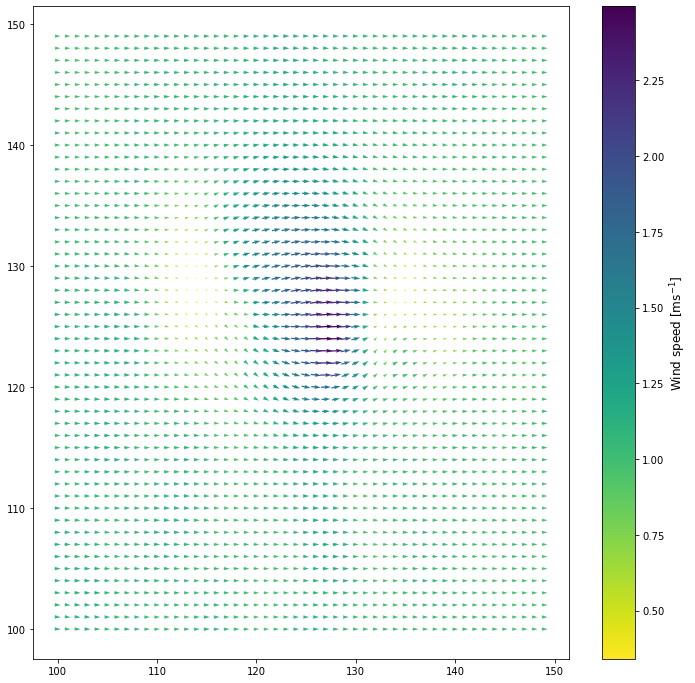

In [4]:
# Wind vector plot over hill

X = np.arange(0, 256)
Y = np.arange(0, 256)

fig, ax = plt.subplots(figsize=(12, 12))
q = ax.quiver(X[100:150], Y[100:150], u[100:150, 100:150], v[100:150, 100:150], wind[100:150, 100:150], cmap='viridis_r', pivot='mid', units='inches')
cbar = fig.colorbar(q)
cbar.ax.set_ylabel('Wind speed [ms$^{-1}$]', fontsize = 12)

# is the wind speed in m/s?

Text(0, 0.5, 'Wind speed [ms$^{-1}$]')

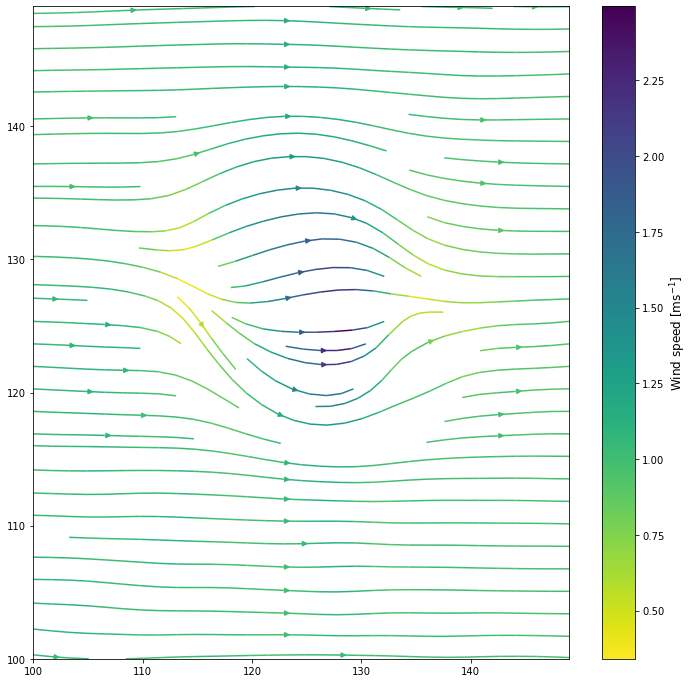

In [5]:
# Wind stream lines over hill

fig, ax = plt.subplots(figsize=(12, 12))
strm = ax.streamplot(X[100:150], Y[100:150], u[100:150, 100:150], v[100:150, 100:150], color=wind[100:150, 100:150], cmap='viridis_r')
cbar = fig.colorbar(strm.lines)
cbar.ax.set_ylabel('Wind speed [ms$^{-1}$]', fontsize = 12)

In [6]:
# Finding the minimum and maximum wind speed
print(wind.min())
print(wind.max())

0.34109544828657035
2.493387764469251


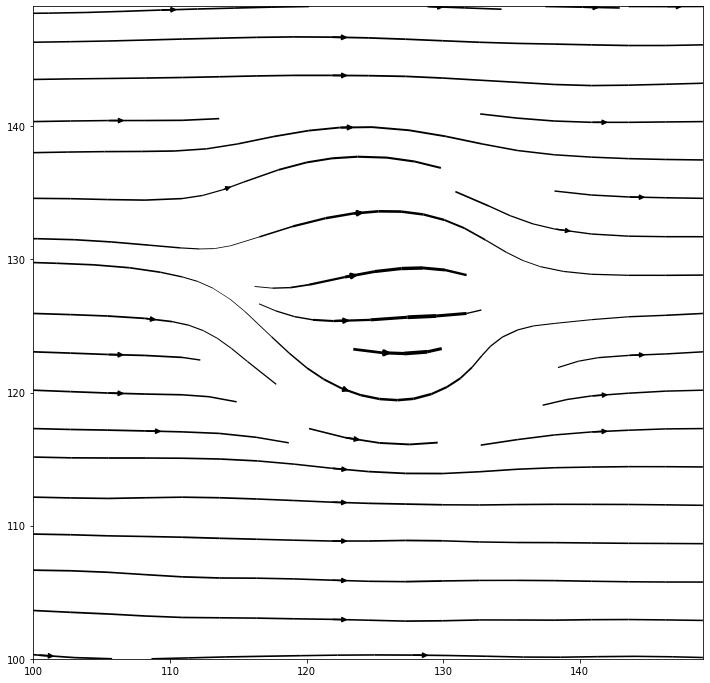

In [7]:
# Vary wind stream linewidth with wind speed

# simple code
X = np.arange(0, 256)
Y = np.arange(0, 256)

fig, ax = plt.subplots(figsize=(12, 12))

lw = 4 * wind[100:150, 100:150] / (wind[100:150, 100:150].max())

ax.streamplot(X[100:150], Y[100:150], u[100:150, 100:150], v[100:150, 100:150], density=0.6, color='k', linewidth=lw)
plt.show()

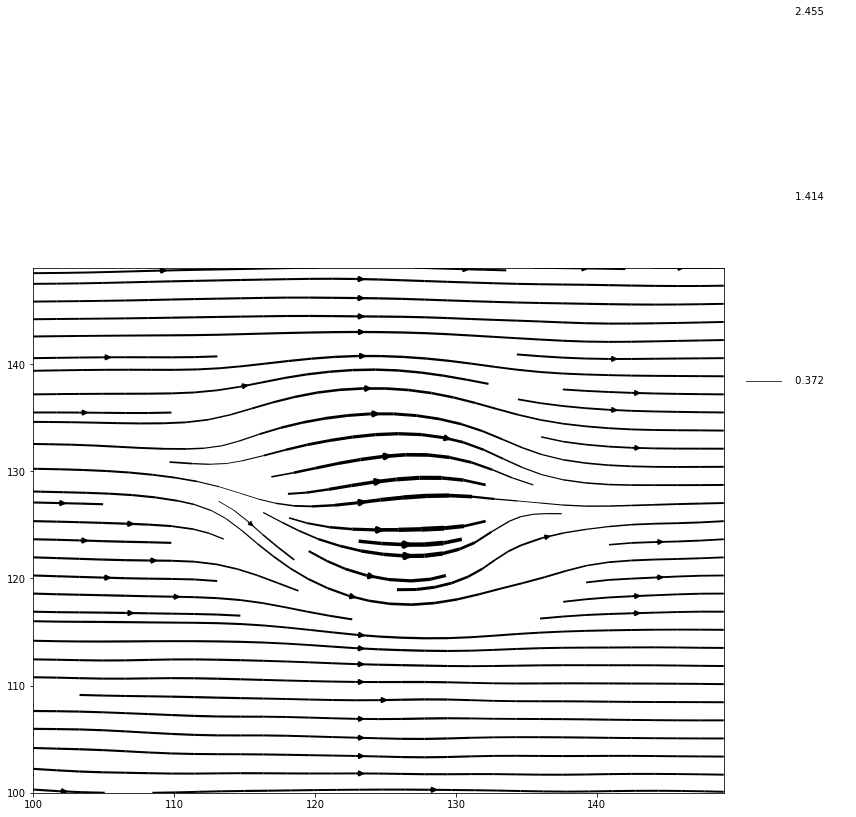

In [8]:
# More sophisticated model for varying stream linewidth with wind speed
import matplotlib.gridspec as gridspec

# Create you figure
fig = plt.figure(figsize=(12, 12))

# Create axes, ax for your plot, and lx for the legend
gs = gridspec.GridSpec(2, 2, height_ratios=(1,2), width_ratios=(6,1))
ax = fig.add_subplot(gs[:, 0])
lx = fig.add_subplot(gs[0, 1])

def windToLW(wind):
    ''' 
    Function to convert windspeed into a sensible linewidth
    This function is somewhat arbitrary and has to be found by trail and error, so that it looks reasonable
    '''
    return wind * 2.

def LWToSpeed(lw):
    ''' The inverse of windToLW, to get the speed back from the linewidth '''
    return (lw) /2

def makeStreamLegend(strm, lx, convertFunc, nlines=5, color='k', fmt='{:g}'):

    ''' Make a legend for a streamplot on a separate axes instance '''

    # Get the linewidths from the streamplot LineCollection
    lws = np.array(strm.lines.get_linewidths())

    # Turn off axes lines and ticks, and set axis limits
    lx.axis('off')
    lx.set_xlim(0, 1)
    lx.set_ylim(0, 1)

    # Loop over the desired number of lines in the legend
    for i, y in enumerate(np.linspace(wind.min(), wind.max(), nlines)):

        # This linewidth
        lw = lws.min()+float(i) * lws.ptp()/float(nlines-1)
        
        # Plot a line in the legend, of the correct length
        lx.axhline(y, 0.1, 0.4, c=color, lw=lw)

        # Add a text label, after converting the lw back to a speed
        lx.text(0.5, y, fmt.format(convertFunc(lw)), va='center')
        
# Make the stream plot
strm = ax.streamplot(X[100:150], Y[100:150], u[100:150, 100:150], v[100:150, 100:150], 
                     color="k", linewidth=windToLW(wind[100:150, 100:150]))

# Add a legend, with nlines lines
makeStreamLegend(strm, lx, LWToSpeed, nlines=3, fmt='{:6.3f}')
plt.tight_layout()

# did not manage to make labels as a tight format

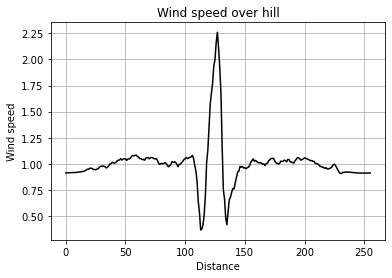

In [9]:
# Wind speed over top of hill
plt.plot(wind[128,:], c = "k")
plt.title("Wind speed over hill")
plt.xlabel("Distance")
plt.ylabel("Wind speed")
plt.grid()

### Plotting vertical wind too

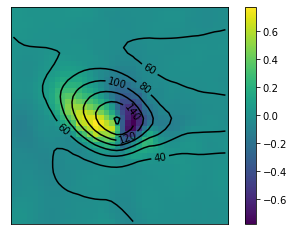

In [10]:
# Plot vertical wind component and topography for 1 km x 1 km area centred on the summit
plt.imshow(w[int(n/2)-20:int(n/2)+20,int(n/2)-20:int(n/2)+20],origin='lower')  # north at the top of the image
plt.colorbar()
cs = plt.contour(z[int(n/2)-20:int(n/2)+20,int(n/2)-20:int(n/2)+20],colors='k',levels=np.arange(0,1000,20))
plt.clabel(cs,fmt='%d')
plt.xticks([])
plt.yticks([])
plt.show()


In [11]:
"""
# 3D plots
from mpl_toolkits.mplot3d import Axes3D

# Vector plot over whole area
# Make the grid
X, Y, Z = np.meshgrid(np.arange(0, 256),
                      np.arange(0, 256),
                      np.arange(0, 256))

fig, ax = plt.subplots(figsize=(12, 12))
ax.quiver(X, Y, Z, u, v, w)

# does not tell a lot
"""

'\n# 3D plots\nfrom mpl_toolkits.mplot3d import Axes3D\n\n# Vector plot over whole area\n# Make the grid\nX, Y, Z = np.meshgrid(np.arange(0, 256),\n                      np.arange(0, 256),\n                      np.arange(0, 256))\n\nfig, ax = plt.subplots(figsize=(12, 12))\nax.quiver(X, Y, Z, u, v, w)\n\n# does not tell a lot\n'

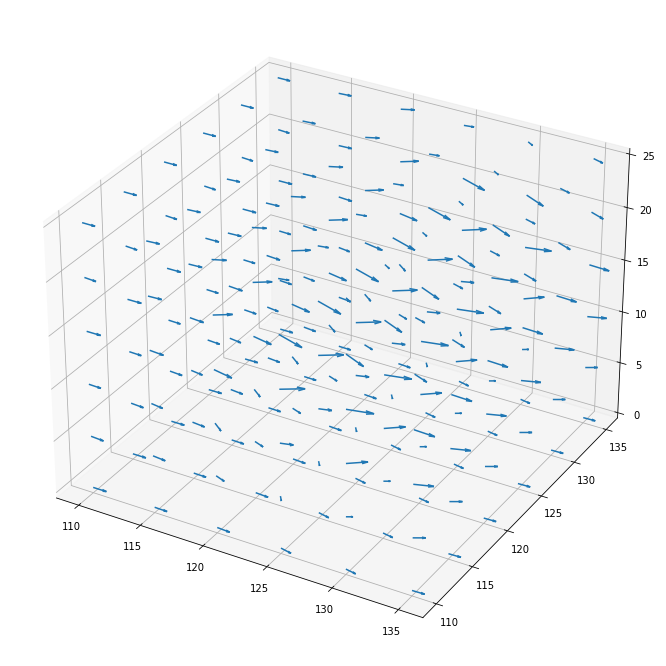

In [12]:
# Wind vector plot over hill
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')

s = 110
e = 140
stp = 5

# Make the grid
X, Y, Z = np.meshgrid(np.arange(s, e, stp),
                      np.arange(s, e, stp),
                      np.arange(0, 30, stp))

# Plot 3D quiver plot
ax.quiver(X, Y, Z, u[s:e:stp, s:e:stp], v[s:e:stp, s:e:stp], w[s:e:stp, s:e:stp])

# maybe add the topogrpahy plot

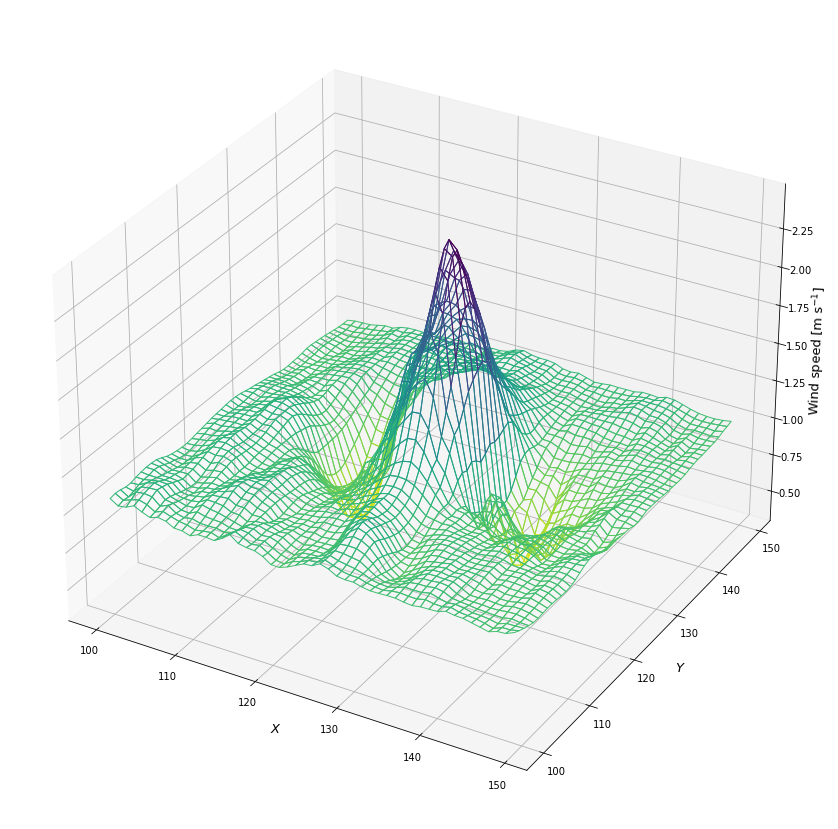

In [13]:
# Wind speed 3d plot around the hill

from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm

#%matplotlib notebook
def surface_plot(data):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(100, 150)
    y = np.arange(100, 150)
    X, Y = np.meshgrid(x, y)

    # Normalize to [0,1]
    Z = data[100:150, 100:150]
    norm = plt.Normalize(Z.min(), Z.max())
    colors = cm.viridis_r(norm(Z))
    rcount, ccount, _ = colors.shape

    surf = ax.plot_surface(X, Y, Z, rcount=rcount, ccount=ccount,
                           facecolors=colors, shade=False)
    surf.set_facecolor((0,0,0,0))


    ax.set_xlabel('$X$', fontsize=13)
    ax.set_ylabel('$Y$', fontsize=13)
    ax.set_zlabel('Wind speed [m s$^{-1}$]', fontsize=13)
    #ax.view_init(30, 110) # change the viewing angle
    
surface_plot(wind)


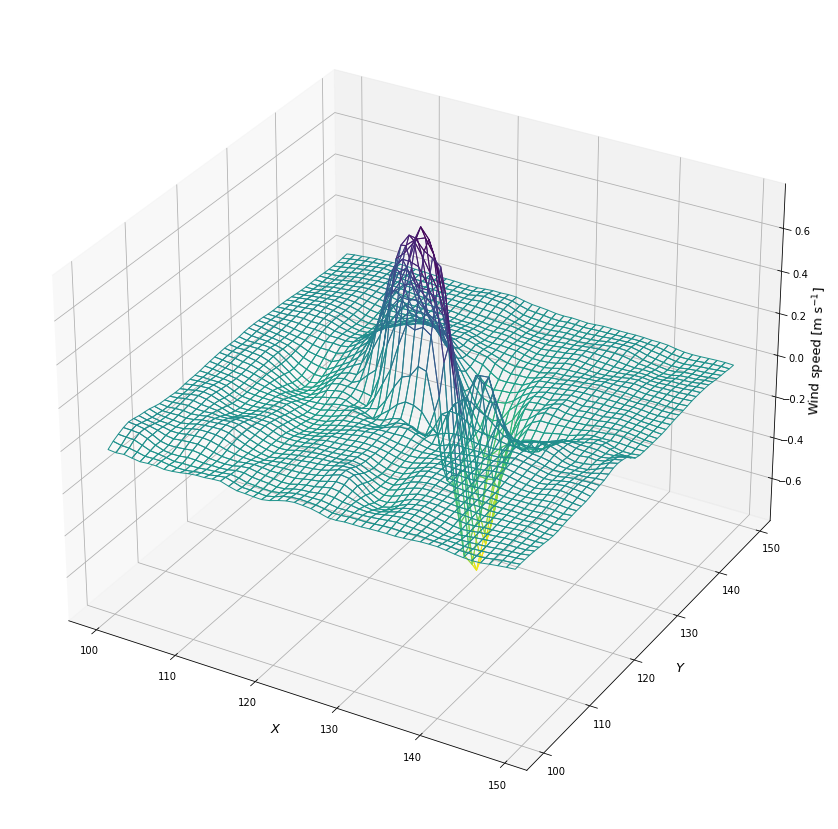

In [14]:
# w component 
surface_plot(w)